In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import os
from google.colab import drive

def getAOC(data):
  AOC = []
  close = data['종가']

  # aoc = (금일 종가 - 전일 종가) / 전일 종가
  for i in range(len(close)):
    aoc_value = ((close[i] - close[i-1]) / close[i-1]) * 100
    if(i % 494 == 0):
      aoc_value = 0
    AOC.append(aoc_value)

  return AOC

drive.mount('/content/drive')

sub=pd.read_csv("./drive/MyDrive/Colab Notebooks/sample_submission.csv")
data=pd.read_csv("./drive/MyDrive/Colab Notebooks/train.csv")

#sort data by "종목명"
subject_Data=data.sort_values(by="종목명",inplace=False)
subject_Data.head()
subject_Data.columns

pv_s_data=pd.pivot_table(subject_Data,values=['거래량', '시가', '고가', '저가', '종가'],index=['종목코드','일자'])

pv_s_data["AOC"] = getAOC(pv_s_data)

divided = pv_s_data.index.get_level_values('종목코드').unique()

sliced_dataframes = []

for i in divided:
    sliced_data = pv_s_data.loc[i]
    sliced_dataframe = sliced_data.reset_index()
    sliced_dataframes.append(sliced_dataframe)

Mounted at /content/drive


In [2]:
#MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['거래량', '고가', '시가', '저가', '종가', 'AOC']
scaled = scaler.fit_transform(sliced_dataframes[200][scale_cols])

In [3]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)

<ipython-input-4-1202195c6716>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)


In [5]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1][-1]))  # 종가만 사용하여 (window, 종가) 형태로 변환
    return ds.batch(batch_size).prefetch(1)

In [7]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

모델 평가 (Model Evaluate)

- 각 epoch와 layer에 따른 정확도를 비교
- 어느 지점부터 학습 손실(train_loss)은 줄어들지만, 검증 손실(val_loss)은 늘어난다면 과적합(Overfitting)이 된 것이라고 판단

In [18]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

def train_and_evaluate(num_epochs, num_layers):
    model = Sequential([
        Conv1D(filters=32, kernel_size=5,
               padding="causal",
               activation="relu",
               input_shape=[WINDOW_SIZE, 1]),
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1),
    ])

    loss = Huber()
    optimizer = Adam(0.0005)
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

    earlystopping = EarlyStopping(monitor='val_loss', patience=20)
    filename = os.path.join('tmp', 'ckeckpointer.ckpt')
    checkpoint = ModelCheckpoint(filename,
                                 save_weights_only=True,
                                 save_best_only=True,
                                 monitor='val_loss',
                                 verbose=1)

    history = model.fit(train_data,
                        validation_data=test_data,
                        epochs=num_epochs,
                        callbacks=[checkpoint, earlystopping],
                        verbose=0)

    return history

In [32]:
epochs_list = [200]  # 변경할 epoch 리스트
layers_list = [5, 10, 30, 50]  # 변경할 LSTM 층 수 리스트

train_loss_dict = {}  # 학습 데이터 손실을 저장할 딕셔너리
val_loss_dict = {}  # 검증 데이터 손실을 저장할 딕셔너리

for num_epochs in epochs_list:
    for num_layers in layers_list:
        print(f"Training for {num_epochs} epochs and {num_layers} layers...")
        history = train_and_evaluate(num_epochs, num_layers)
        key = f"{num_epochs} epochs, {num_layers} layers"

        train_loss_dict[key] = history.history['loss']
        val_loss_dict[key] = history.history['val_loss']

Training for 200 epochs and 5 layers...

Epoch 1: val_loss improved from inf to 0.01464, saving model to tmp/ckeckpointer.ckpt

Epoch 2: val_loss improved from 0.01464 to 0.00093, saving model to tmp/ckeckpointer.ckpt

Epoch 3: val_loss did not improve from 0.00093

Epoch 4: val_loss did not improve from 0.00093

Epoch 5: val_loss did not improve from 0.00093

Epoch 6: val_loss did not improve from 0.00093

Epoch 7: val_loss did not improve from 0.00093

Epoch 8: val_loss did not improve from 0.00093

Epoch 9: val_loss did not improve from 0.00093

Epoch 10: val_loss did not improve from 0.00093

Epoch 11: val_loss did not improve from 0.00093

Epoch 12: val_loss did not improve from 0.00093

Epoch 13: val_loss did not improve from 0.00093

Epoch 14: val_loss improved from 0.00093 to 0.00092, saving model to tmp/ckeckpointer.ckpt

Epoch 15: val_loss improved from 0.00092 to 0.00092, saving model to tmp/ckeckpointer.ckpt

Epoch 16: val_loss improved from 0.00092 to 0.00091, saving model

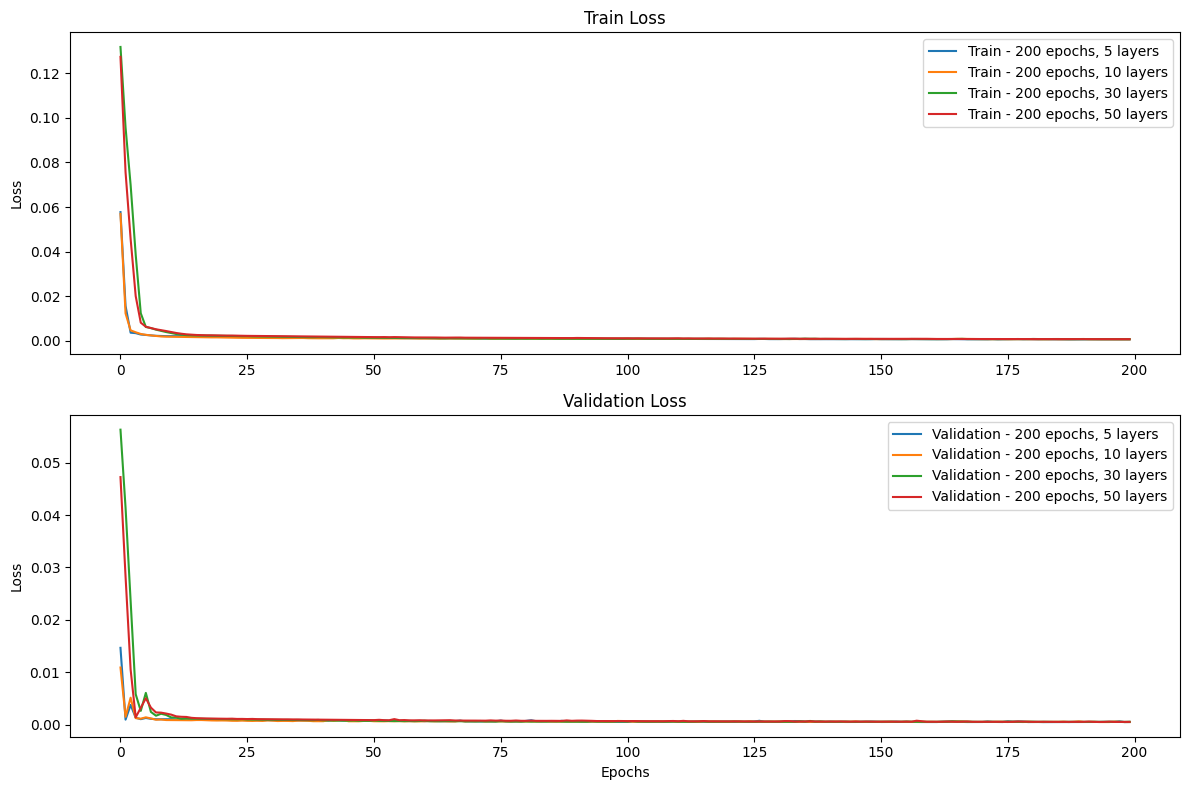

In [33]:
# 결과 그래프로 plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 학습 손실 그래프
for key, train_loss in train_loss_dict.items():
    ax1.plot(train_loss, label=f'Train - {key}')

ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')
ax1.legend()

# 검증 손실 그래프
for key, val_loss in val_loss_dict.items():
    ax2.plot(val_loss, label=f'Validation - {key}')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss')
ax2.legend()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()